In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import numpy as np
import pandas as pd
import json
from datetime import datetime as dt

import scipy

import networkx as nx
import matplotlib.pyplot as plt
import datetime

import matplotlib.image as mpimg

import community

from sklearn.cluster import KMeans

import nltk
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

import seaborn as sns

import gensim
from gensim import corpora
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud

from gensim.models import Phrases

from gensim.corpora import Dictionary

from gensim.models import Word2Vec

import random
seed_value = 42
random.seed(seed_value)

from IPython.display import Image

#!pip3 install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim

import gensim.downloader as api
from gensim.test.utils import datapath

from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE

#conda install --channel conda-forge pygraphviz
#!pip install pygraphviz
import pygraphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc

from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import label_binarize

from sklearn.metrics import silhouette_score

from collections import Counter

# !pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Harshita\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def extractcoor(data):
    if data and len(data["coordinates"]) == 2:
        return data["coordinates"][0], data["coordinates"][1]
    return None,None    

def usermention(data):
    ids, handles = [], []
    # all the user ids and their handles and concatinated into a string with a seperator
    for d in data['user_mentions']:
        ids.append(d["id_str"])
        handles.append(d["screen_name"])
    return ids, handles    

def extracthashtags(data):
    tags = ""
    # all the hastags are concatinated into one string with a hash as a seperator
    for d in data['hashtags']:
        tags += "#"+d["text"]       
    return tags    

def retweetids(data):
    ids, handles = [], []
    # all the user ids and their handles and concatinated into a string with a seperator
    for d in data['user_mentions']:
        ids.append(d["id_str"])
    return ids 

def processfile(file):
    data, ids = [], []
    with open(file) as fl:
        for l in fl:
            l = json.loads(l)
            if "id" in l:
                tid = l["id_str"]
                ids.append(tid)
                lang = l['lang']
                time = l['timestamp_ms']
                #long, lat = extractcoor(l["coordinates"])
                userid, handel = l['user']['id'], l['user']['screen_name']
                u_mention, m_han = usermention(l['entities'])
                tags = extracthashtags(l['entities'])
                txt = l['text']
                if "retweeted_status" in l:
                    r_id = retweetids(l['retweeted_status']['entities'])
                #data.append([tid,lang,time,long,lat,userid,handel,mention,m_han,tags])
                data.append([tid,lang,time,userid,handel,u_mention,m_han,r_id,tags,txt])
                
    #df = pd.DataFrame(data, columns=["t_id", "lang", "time", "long", "lat", "u_id", "u_han", "u_ment", "m_han", "tags"])
    df = pd.DataFrame(data, columns=["t_id", "lang", "time", "u_id", "u_han", "u_mention", "m_han","r_id", "tags","txt"])
    #df = df.drop_duplicates()
    return df

In [3]:
import os
path1='C:/Users/Harshita/Exeter/Dissertation/econtwitter/final1.json'
filename='finalcsv2'
def gencsv():
    df = processfile(path1)
    df.to_csv(filename+".csv", index=False)
    return df

EXPLANATION : Twitter provides different forms of interactions between the users: follows, mentions, replies, and retweets. The most useful indicator of social ties between the Twitter users are retweets. When a user retweets a post, it is distributed to all of its followers, just as if it were an originally authored post. Users retweet content that they find interesting or agreeable. Despite the fact that it does not always signify an endorsement, in large number of cases retweets indicate links between the like-minded users.


Ref : https://appliednetsci.springeropen.com/articles/10.1007/s41109-016-0001-4

In [4]:
def load_gephi_images(img_name,figsize=(10, 8)):
    path=f'C:/Users/Harshita/Exeter/Dissertation/Gephi/{img_name}'
    #print(path)    
    img = mpimg.imread(path)
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title('Network graph based on user and retweet users')
    plt.axis('off')
    plt.show()

In [5]:
def plot_graph(graph_type, X, X_label, Y, Y_label, plt_title, highlight_clusters=None, args=None , rot=90, tic=None):
    plt.figure(figsize=(10, 6))
    if graph_type == "scatter":
        plt.scatter(X, Y, marker="^", c="pink", edgecolor="green", s=80)
    elif graph_type == "bar":
        if highlight_clusters:
            highlight_colors = ['orange' if i in highlight_clusters else 'blue' for i in X]
            plt.bar(X, Y, color=highlight_colors)
        else:
            plt.bar(X, Y)
            plt.yscale("log")
    elif graph_type=="line":
        for window_size in args:
            plt.plot(X[X['Window'] == window_size]['Vector Size'].values, Y[Y['Window'] == window_size]['Accuracy'].values, label=f"Window Size {window_size}")
            #plt.plot(X[X['Window'] == window_size]['Vector Size'].values, Y[Y['Window'] == window_size]['F1 Score'].values,)
        plt.legend()
        plt.grid()
        
    if highlight_clusters:
        legend_labels = ["Top Cluster" if cluster in highlight_clusters else "Other Clusters" for cluster in X]
        plt.legend(legend_labels)
        
    plt.xlabel(X_label)
    plt.ylabel(Y_label)
    plt.title(plt_title)
    plt.xticks(rotation=rot,ticks=tic)  # Rotate x-axis labels if needed
    plt.show()
      

In [6]:
def plot_network(giant_graph,pos,plt_title,with_labels=False, node_size=20, alpha=0.5):
    plt.figure(figsize=(10, 10))
    nx.draw_networkx(giant_graph, pos, with_labels=with_labels, node_size=node_size, alpha=alpha)
    plt.title(plt_title)
    plt.axis('off')
    plt.show()    

In [7]:
def hourly_distribution(data):
    # Convert 'time' column to datetime with milliseconds precision
    data['time'] = pd.to_datetime(data['time'], unit='ms')
    
    # Extract hour from timestamp
    data['hour'] = data['time'].dt.hour
    
    # Create a histogram of hourly distribution
    plt.figure(figsize=(10, 6))
    plt.hist(data['hour'], bins=24, edgecolor='black', alpha=0.7)
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Tweets')
    plt.title('Hourly Distribution of Tweets')
    plt.xticks(range(24))
    plt.grid()
    plt.show()
    
    
def hashtag_analysis(data):    
    # Extract individual hashtags from the combined string format
    all_hashtags = [tag.lower() for tags in data['tags'].str.split('#') if isinstance(tags, list) for tag in tags if tag]
    
    # Count hashtag frequencies
    hashtag_counts = pd.Series(all_hashtags).value_counts()
    
    # Plot the top and least N hashtags
    top_n = 5  # Change this value to show more or fewer top and least hashtags
    plt.figure(figsize=(12, 8))
    
    # Plot top hashtags
    plt.subplot(2, 1, 1)
    hashtag_counts[1:top_n].plot(kind='bar', color='skyblue', alpha=0.7)
    plt.xlabel('Top Hashtag')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Hashtags')
    plt.xticks(rotation=45)
    
    # Plot least hashtags
    plt.subplot(2, 1, 2)
    hashtag_counts[-top_n:].plot(kind='bar', color='salmon', alpha=0.7)
    plt.xlabel('Least Hashtag')
    plt.ylabel('Frequency')
    plt.title(f'Least {top_n} Hashtags')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()
    
def perform_EDA(data):
    hourly_distribution(data)
    hashtag_analysis(data)

In [8]:
def handle_repeated_characters(text):
    # Identify words with repeated characters using regular expressions
    repeated_pattern = r'(\w)\1{2,}'
    matches = re.findall(repeated_pattern, text)

    # Replace repeated characters in the identified words
    for match in matches:
        replacement = match[0]  # Keep only a single occurrence of the repeated character
        text = re.sub(match, replacement, text)    
    return text


def handle_elongated_words(text):
    elongated_words = re.findall(r'(\w*)(\w)\2(\w*)', text)
    for word in elongated_words:
        corrected_word = ''.join(ch for ch, _ in re.findall(r'((\w)\2*)', ''.join(word)))
        text = text.replace(''.join(word), corrected_word)
    return text


def remove_short_words(text, min_length=3):
    words = text.split()
    filtered_words = [word for word in words if len(word) >= min_length]
    return ' '.join(filtered_words)


def  process_message(review_text):
    
    eng_stops = set(stopwords.words("english"))
    lemmatizer = WordNetLemmatizer()
    
    # remove all the special characters
    new_review_text = re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "",review_text) 
    new_review_text = re.sub(r"user", "",new_review_text, flags=re.IGNORECASE)
    new_review_text = re.sub(r"econtwitter", "",new_review_text, flags=re.IGNORECASE)
    new_review_text = re.sub(r"economic", "",new_review_text, flags=re.IGNORECASE)
    new_review_text = re.sub(r"hi", "",new_review_text, flags=re.IGNORECASE)
    new_review_text = re.sub(r"u", "",new_review_text, flags=re.IGNORECASE)
    new_review_text = re.sub(r"rt", "",new_review_text, flags=re.IGNORECASE)
    new_review_text = re.sub(r"yor", "",new_review_text, flags=re.IGNORECASE)

    new_review_text = handle_repeated_characters(new_review_text)
    new_review_text = handle_elongated_words(new_review_text)
    new_review_text = remove_short_words(new_review_text)

    # convert all letters to lower case
    words = new_review_text.lower().split()
    #Stopword removal
    words = [w for w in words if not w in eng_stops]
    # lemmatizer
    words = [lemmatizer.lemmatize(word) for word in words]
    # join all words back to text
    return (" ".join(words))

In [9]:
def genWordCloud(txt,background_color='black'):
    # Create a WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color=background_color).generate(txt)
    # Plot the WordCloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud for tweets')
    plt.show()

In [10]:
def perform_LDA(subset_giant, seed, cls, min_val=20, max_val=0.5, topic_count=5, topic_wrd=7):
    preprocessed_tweets_0 = subset_giant['clean_tweet'][subset_giant.cluster == cls].tolist()
    tokenized_tweets_0 = [word_tokenize(tweet) for tweet in preprocessed_tweets_0]

    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram_0 = Phrases(tokenized_tweets_0, min_count=min_val)
    for idx in range(len(tokenized_tweets_0)):
        for token in bigram_0[tokenized_tweets_0[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                tokenized_tweets_0[idx].append(token)

    # Create a dictionary from the tokenized tweets
    dictionary_0 = corpora.Dictionary(tokenized_tweets_0)

    # Filter out words that occur less than 20 tweets, or more than 50% of the tweets.
    dictionary_0.filter_extremes(no_below=min_val, no_above=max_val)

    # Create a document-term matrix
    corpus_0 = [dictionary_0.doc2bow(tokens) for tokens in tokenized_tweets_0]

    # Train the LDA model
    num_topics = topic_count  # Number of desired topics
    lda_model_0 = gensim.models.LdaModel(corpus=corpus_0, id2word=dictionary_0, num_topics=num_topics, passes=10, random_state=seed)

    # Print the topics and associated words
    topics_0 = lda_model_0.print_topics(num_words=topic_wrd)
    print(f"Topic {cls} :")
    for topic in topics_0:
        print(topic)
        print("\n")
        
#     # Visualize the topics
#     pyLDAvis.enable_notebook()
#     vis_0 = pyLDAvis.gensim.prepare(lda_model_0, corpus_0, dictionary_0)

In [11]:
def word_vector(tokens, size, model_w2v):
    vec = np.zeros(size).reshape((1, size))
    count = 0
    for word in tokens:
        try:
            vec += model_w2v.wv[word].reshape((1, size))
            count += 1.
        except KeyError:  # handling the case where the token is not in vocabulary
            continue
    if count != 0:
        vec /= count
    return vec

In [12]:
def rfClassifier(X_train, y_train, X_test, y_test, random):
    rf_classifier = RandomForestClassifier(random_state=random)
    rf_classifier.fit(X_train, y_train)
    y_pred = rf_classifier.predict(X_test)
    current_f1_score = f1_score(y_test, y_pred, average='weighted')    
    return current_f1_score, rf_classifier, y_pred

In [13]:
def svmClassifier(X_train, y_train, X_test, y_test, random, C=1.0, kernel='linear'):
    svm = SVC(C=C, kernel=kernel)
    svm.fit(X_train, y_train)
    y_pred = svm.predict(X_test)
    current_f1_score = f1_score(y_test, y_pred, average='weighted')
    return current_f1_score, svm, y_pred

In [14]:
def w2vec_hyperparameters(X_train, y_train, X_test, y_test, seed_value, vector_sizes, windows, model):
    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
    y_train.reset_index(drop=True, inplace=True)
    y_test.reset_index(drop=True, inplace=True)

    param_combinations = []
    f1_scores = []
    accuracy = []

    for vector_size in vector_sizes:
        for window in windows:
            w2v_model = Word2Vec(sentences=X_train, vector_size=vector_size, window=window, min_count=1, sg=1)
            
            wordvec_arrays_train = np.zeros((len(X_train), vector_size))
            wordvec_arrays_test = np.zeros((len(X_test), vector_size))
            
            for i in range(len(X_train)):
                try:
                    wordvec_arrays_train[i, :] = word_vector(X_train[i], vector_size, w2v_model)
                except IndexError:
                    continue

            for i in range(len(X_test)):
                try:
                    wordvec_arrays_test[i, :] = word_vector(X_test[i], vector_size, w2v_model)
                except IndexError:
                    continue          
            

            if model=="RFC":
                current_f1_score, rf_classifier, y_pred = rfClassifier(wordvec_arrays_train, y_train, wordvec_arrays_test, y_test, seed_value)
            elif model == "SVM":
                current_f1_score, svm_classifier, y_pred = svmClassifier(wordvec_arrays_train, y_train, wordvec_arrays_test, y_test, seed_value)
            

            f1_scores.append(current_f1_score)
            acc_score = accuracy_score(y_test, y_pred)
            accuracy.append(acc_score)
            param_combinations.append((vector_size, window))

    results_df = pd.DataFrame({'Vector Size': [param[0] for param in param_combinations],
                               'Window': [param[1] for param in param_combinations],
                               'Accuracy': accuracy})
    return results_df

In [15]:
def kmeans_hyperparameters(cluster_range, feature_matrix, seed_value):
    silhouette_scores = []
    kmeans_models = []
    
    for n_clusters in cluster_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=seed_value)
        kmeans.fit(feature_matrix)
        kmeans_models.append(kmeans)
        labels = kmeans.labels_
        silhouette_avg = silhouette_score(feature_matrix, labels)
        silhouette_scores.append(silhouette_avg)

    best_num_clusters = cluster_range[silhouette_scores.index(max(silhouette_scores))]
    best_kmeans_model = kmeans_models[silhouette_scores.index(max(silhouette_scores))]
    
    return best_num_clusters, silhouette_scores

In [16]:
def svm_hyperparameters(X_train, y_train, X_test, y_test, seed_value):    
    svc=SVC(random_state=seed_value)
    
    param_grid = {'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly', 'rbf'],}  # Kernel type
    
    # Instantiate GridSearchCV for hyperparameter tuning
    grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', cv=5)

    # Fit the grid search to the data
    grid_search.fit(X_train, y_train)

    # Get the results as a DataFrame
    results = pd.DataFrame(grid_search.cv_results_)

    # Plot the results
    plt.figure(figsize=(10, 6))
    for kernel in param_grid['kernel']:
        kernel_results = results[results['param_kernel'] == kernel]
        plt.plot(kernel_results['param_C'], kernel_results['mean_test_score'], label=f'Kernel: {kernel}')

    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('Mean Cross-Validated Accuracy')
    plt.title('Hyperparameter Tuning of SVM')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Get the best parameters and best accuracy
    best_params = grid_search.best_params_
    best_accuracy = grid_search.best_score_

    # Use the best parameters to evaluate on the test set
    best_svc = SVC(**best_params)
    best_svc.fit(X_train, y_train)
    y_pred = best_svc.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)

    print("Best parameters:", best_params)
    print("Best cross-validated accuracy:", best_accuracy)
    print("Test accuracy with best parameters:", test_accuracy)
    
    return best_params, best_accuracy, test_accuracy

In [17]:
def tweet_vector(tokenized_tweet, vec_size, model):
    wordvec_arrays = np.zeros((len(tokenized_tweet), vec_size))
    for i, tweet in enumerate(tokenized_tweet):
        wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], vec_size,model)
    return wordvec_arrays

In [18]:
def reduce_dimensions(model):
    num_dimensions = 2

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


def plot_with_matplotlib_labels(x_vals, y_vals, labels):
    random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 30)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))
        
        
def plot_with_matplotlib_fixed_words(x_vals, y_vals, labels,fixed_words):
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)
    
    for i, label in enumerate(labels):
        if label in fixed_words:
            plt.scatter(x_vals[i], y_vals[i], color='red', s=100, label=label)
            plt.annotate(label, (x_vals[i], y_vals[i]),backgroundcolor='white')

In [19]:
def plot_roc_curve(y_test, y_pred, n_classes, top_classes=5, seed_value=42):
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    y_pred_bin = label_binarize(y_pred, classes=np.arange(n_classes))
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_bin[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    plt.figure(figsize=(10, 8))

    # Sort classes by AUC scores
    sorted_classes = sorted(range(n_classes), key=lambda i: roc_auc[i], reverse=True)

    # Plot ROC curves for top N classes
    plotted_classes = 0
    for i in sorted_classes:
        if not np.isnan(roc_auc[i]):
            plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
            plotted_classes += 1
            if plotted_classes >= top_classes:
                break

    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.title('ROC Curve with legend for top 5 classes', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.tick_params(labelsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.tight_layout()
    plt.show()

In [20]:
def conf_matrix_3d(class_labels, conf_matrix, xlabel , ylabel, zlabel, title):
    # Create a meshgrid for the 3D plot
    x, y = np.meshgrid(np.arange(len(class_labels)), np.arange(len(class_labels)))

    # Flatten the meshgrid and confusion matrix for plotting
    x = x.flatten()
    y = y.flatten()
    z = conf_matrix.flatten()

    # Create the 3D plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the 3D bars
    ax.bar3d(x, y, np.zeros(len(z)), 0.5, 0.5, z, shade=True)

    # Set axis labels and title
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_yticklabels(class_labels)
    ax.set_title(title)
    # Show the plot
    plt.show()    

In [21]:
def plot_heatmap(conf_matrix, class_labels, xlabel , ylabel, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()    

In [22]:
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    return score

In [23]:
def main():
    #Loading data and forming a dataframe
    df_prep = gencsv()
    
    perform_EDA(df_prep)
    
    unique_values = df_prep['lang'].value_counts().index.tolist()

    # Get the unique values and their counts from the "lang" column
    lang_counts = df_prep['lang'].value_counts()
    
    #Checking for language distribution in all tweets
    plot_graph(graph_type='bar', X=lang_counts.index, X_label='Language', Y=lang_counts.values, Y_label='Count', plt_title='Distribution of Languages', rot=90)

    
    #92.2% tweets are in "English", so removing the other language tweets and forming a new dataframe
    df = df_prep[df_prep['lang'] == 'en'].copy()
    
    # Creating a weighted DiGraph "G" based on user ID and retweet ID
    df_graph= df[['u_id', 'r_id']].copy()
    df_graph = df_graph[df_graph['r_id'].apply(lambda x: len(x) > 0)]
    df_graph = df_graph.explode('r_id')
    # Group by 'u_id' and 'r_id' and count the retweet frequency
    retweet_counts = df_graph.groupby(['u_id', 'r_id']).size().reset_index(name='retweet_count')
    # Calculate the weights based on retweet frequency
    retweet_counts['weight'] = retweet_counts['retweet_count']
    # Reset the index because of explode method above
    retweet_counts = retweet_counts.reset_index(drop=True)
    G = nx.from_pandas_edgelist(retweet_counts, 'u_id', 'r_id', edge_attr='weight',  create_using=nx.DiGraph()) #Turn df into graph
    
    #Visualization using NetworkX did not provide a visually appealing graph, so used software Gephi for the same
    #Extracting data from graph "G" into csv files to load into Gephi
    # Get a list of nodes
    nodes = list(G.nodes())
    # Get a list of edges with their corresponding weights
    edges = [(u, v, G[u][v]['weight']) for u, v in G.edges()]
    # Create a DataFrame for nodes
    nodes_df = pd.DataFrame(nodes, columns=['ID'])
    # Create a DataFrame for edges
    edges_df = pd.DataFrame(edges, columns=['Source', 'Target', 'Weight'])
    # Save nodes and edges to CSV
    nodes_df.to_csv('nodes.csv', index=False)
    edges_df.to_csv('edges.csv', index=False)
    
    #Loading outputs from gephi
    load_gephi_images('2_F_entireNetwork.png') #Graph network based on user and users that retweeted
    load_gephi_images('4_F_stronglyConnected.png') #Giant component
    
    #Importing Nodes data from Gephi
    dfz = pd.read_csv('C:/Users/Harshita/Exeter/Dissertation/Gephi/Connected_graph_nodes.csv')
    
    # 1. CONNECTED COMPONENT
    # Count the occurrences of each value in the "strongcompnum" column
    value_counts = dfz['strongcompnum'].value_counts() 
    #Visualization of strongly connected component
    plot_graph(graph_type='scatter', X=value_counts.index, X_label='Strong Component ID', Y=value_counts.values, Y_label='Frequency (No of nodes)', plt_title='Frequency of Strong Component ID', rot=45)
    
    # 2. STATISTICAL COMMUNITY DETECTION
    load_gephi_images('5_F_StatisticalCommunityDetection_4.png') #Giant component
    
    # 3. MODULARITY COMMUNITY DETECTION
    load_gephi_images('6_F_ModularityCommunityDetection_2.png') #Giant component
    
    
    # Creating a giant network from python (scratch)
    G_undirected = G.to_undirected()
    components = list(nx.connected_components(G_undirected))

    # Find the largest connected component (giant component)
    giant_component = max(components, key=len)
    # Extract the nodes and edges of the giant component
    giant_nodes = list(giant_component)
    giant_edges = G_undirected.subgraph(giant_nodes).edges()

    # Create a new graph containing only the giant component
    giant_graph = nx.Graph()
    giant_graph.add_nodes_from(giant_nodes)
    giant_graph.add_edges_from(giant_edges)

    # Visualize the giant component
    pos = nx.spring_layout(giant_graph, seed=seed_value)    
    plot_network(giant_graph, pos, 'Giant Component')
    
    # K-means algorithm : SCENARIO : based on betweenness and closeness
    # Example: Node betweenness centrality and closeness centrality
    betweenness = nx.betweenness_centrality(giant_graph)
    closeness = nx.closeness_centrality(giant_graph)

    # Create feature matrix using the defined features
    feature_matrix = np.array([[betweenness[node], closeness[node]] for node in giant_graph.nodes()])
    
########### UNCOMMENT ONLY IF YOU NEED TO RUN THE HYPERPARAMETERS EVALUATION AGAIN ############
# # ###########################################################################################    
# #     # HYPER PARAMETER TUNING FOR k-MEANS on my data
# #     # Define a range of cluster numbers to try
# #     cluster_range = range(2, 51)  # Try clusters from 2 to 20

# #     # Perform hyperparameter tuning
# #     best_num, silhouette_scores = kmeans_hyperparameters(cluster_range, feature_matrix, seed_value)

# #     # Print the best number of clusters
# #     print(f"Best number of clusters: {best_num}")
    
    
# #     # Plot the silhouette scores for different cluster numbers
# #     plt.figure(figsize=(10, 6))
# #     plt.plot(cluster_range, silhouette_scores, marker='o', label='Silhouette Score')
# #     plt.scatter(best_num, max(silhouette_scores), color='red')
# #     plt.xlabel('Number of Clusters')
# #     plt.ylabel('Silhouette Score')
# #     plt.title('Silhouette Score vs. Number of Clusters')
# #     plt.grid(True)
# #     plt.legend()
# #     plt.show()

# #     # Best parameter values : clusters = 40, silhouette score : 0.61

# # ###########################################################################################

    # Apply K-means algorithm with its correct hyperparameters
    kmeans = KMeans(n_clusters=40, random_state=seed_value)
    kmeans.fit(feature_matrix)

    # Obtain the cluster labels for each node
    cluster_labels = kmeans.labels_

    
    # Count the frequency of each cluster
    cluster_counts = np.bincount(cluster_labels)

    # Generate x-axis values for the clusters
    x_values = np.arange(len(cluster_counts))
    
    # Get the top 3 clusters on the basis of their frequency
    top_clusters = Counter(cluster_labels).most_common(3)
    
    # Get the top 3 clusters on the basis of their frequency
    top_clusters = Counter(cluster_labels).most_common(3)
    highlight_clusters = [cluster for cluster, _ in top_clusters]

    # Create the bar graph and highlight the top clusters
    plot_graph(graph_type="bar", X=x_values, X_label="Cluster", Y=cluster_counts, Y_label="Frequency", plt_title="Cluster Frequency", highlight_clusters=highlight_clusters, rot=0, tic=x_values)
    
    print(f"Top 3 clusters : {highlight_clusters}")

    
    # Assign cluster labels as node attributes
    for i, node in enumerate(giant_graph.nodes()):
        giant_graph.nodes[node]['cluster'] = cluster_labels[i]

    # Visualize the graph with communities
    pos = nx.spring_layout(giant_graph)
    plt.figure(figsize=(10, 10))
    nodes = nx.draw_networkx_nodes(giant_graph, pos, node_size=20, cmap=plt.cm.cool, node_color=cluster_labels, alpha=0.8)
    nodes.set_edgecolor('k')
    nx.draw_networkx_edges(giant_graph, pos, width=0.3, alpha=0.2, edge_color='black')
    plt.axis('off')
    plt.tight_layout()
    plt.title('Community detection for 40 Clusters')
    plt.show()
    
    # Create a DataFrame with columns u_id and cluster_labels
    df_g = pd.DataFrame({'u_id': giant_graph.nodes,'cluster': cluster_labels})
    
    merged_df = df.merge(df_g, on='u_id', how='left')
    
    subset_minor = merged_df[merged_df['cluster'].isna()]
    subset_minor = subset_minor[['t_id','lang','u_id','u_mention','tags','cluster','txt']]
    subset_giant = merged_df[merged_df['cluster'].notna()]
    subset_giant = subset_giant[['t_id','lang','u_id','u_mention','tags','cluster','txt']]
    
    subset_giant['clean_tweet']=subset_giant['txt'].apply(lambda x: process_message(x))
    subset_giant.reset_index(drop=True, inplace=True)
    
    #Calculating sentiment polarity scores
    subset_giant['senti_score'] = (subset_giant['clean_tweet']).apply(sentiment_analyzer_scores)
    
    text_all=" ".join(subset_giant['clean_tweet'])    
    genWordCloud(txt=text_all,background_color='white')
    plt.tight_layout()  # Adjust spacing between subplots
    plt.show()
    
    
    # Performing LDA
    perform_LDA(subset_giant, seed=seed_value, cls=4.0, min_val=20, max_val=0.5, topic_count=3, topic_wrd=7)
    perform_LDA(subset_giant, seed=seed_value, cls=10.0, min_val=20, max_val=0.5, topic_count=3, topic_wrd=7)
    perform_LDA(subset_giant, seed=seed_value, cls=18.0, min_val=20, max_val=0.5, topic_count=3, topic_wrd=7)

    subset_giant.reset_index(drop=True, inplace=True)
    
    
    
########### UNCOMMENT ONLY IF YOU NEED TO RUN THE HYPERPARAMETERS EVALUATION AGAIN ############    
#     #########################################################################################
    
#     # WORD2VEC - Random Forest
#     # TUNING THE HYPERPARAMETERS
#     # Step 1: Prepare the data and tokenize sentences
#     subset_giant['tokenized_tweet'] = subset_giant['clean_tweet'].apply(lambda x: x.split())

#     # Step 2: Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(subset_giant['tokenized_tweet'], subset_giant['cluster'], test_size=0.2, random_state=seed_value)

#     # Hyperparameter combinations to try
#     vector_sizes = [50, 100, 200, 300]
#     windows = [3, 5, 7, 10]

#     results_df = w2vec_hyperparameters(X_train, y_train, X_test, y_test, seed_value, vector_sizes, windows, model="RFC")
    
#     # Line plot for F1 scores with different vector sizes
#     plot_graph("line", results_df, "Vector Size", results_df, "Accuracy", "Accuracy for Different Vector Sizes", rot=0, tic=None, args = windows)
    
#     # Step 9: Choose the best hyperparameters based on the highest F1 score
#     best_params = results_df.loc[results_df['Accuracy'].idxmax()]
#     print("Best Hyperparameters:")
#     print(f"Vector Size: {best_params['Vector Size']}")
#     print(f"Window Size: {best_params['Window']}")
#     print(f"Accuracy Score: {best_params['Accuracy']}")
    
#     #Best Parameters : Vector Size = 100 , Window = 10, accuracy = 0.60
    
#     ##########################################################################################
    
#     # WORD2VEC - SVM
#     # TUNING THE HYPERPARAMETERS
#     # Step 1: Prepare the data and tokenize sentences
#     subset_giant['tokenized_tweet'] = subset_giant['clean_tweet'].apply(lambda x: x.split())

#     # Step 2: Split the data into training and testing sets
#     X_train, X_test, y_train, y_test = train_test_split(subset_giant['tokenized_tweet'], subset_giant['cluster'], test_size=0.2, random_state=seed_value)

#     # Hyperparameter combinations to try
#     vector_sizes = [50, 100, 200, 300]
#     windows = [3, 5, 7, 10]

#     results_df = w2vec_hyperparameters(X_train, y_train, X_test, y_test, seed_value, vector_sizes, windows, model="SVM")
    
#     # Line plot for F1 scores with different vector sizes
#     plot_graph("line", results_df, "Vector Size", results_df, "Accuracy", "Accuracy for Different Vector Sizes", rot=0, tic=None, args = windows)
    
#     # Step 9: Choose the best hyperparameters based on the highest F1 score
#     best_params = results_df.loc[results_df['Accuracy'].idxmax()]
#     print("Best Hyperparameters:")
#     print(f"Vector Size: {best_params['Vector Size']}")
#     print(f"Window Size: {best_params['Window']}")
#     print(f"Accuracy Score: {best_params['Accuracy']}")
    
#     #Best Parameters : Vector Size = 300 , Window = 7, accuracy= 0.74
    
#     #############################################################################################
    
    tokenized_tweet = subset_giant['clean_tweet'].apply(lambda x: x.split()) # tokenizing
    tokenized_tweet.reset_index(drop=True, inplace=True)

    model_w2v = gensim.models.Word2Vec(
                tokenized_tweet,
                vector_size=300, # desired no. of features/independent variables
                window=7, # context window size
                min_count=2, # Ignores all words with total frequency lower than 2.                                  
                sg = 1, # 1 for skip-gram model
                hs = 0,
                negative = 10, # for negative sampling
                workers= 32, # no.of cores
                seed = seed_value
    )
    
    
    x_vals, y_vals, labels = reduce_dimensions(model_w2v)
    
    #plot_with_matplotlib_labels(x_vals, y_vals, labels, subset_giant['color'], legend_labels)
    
    plot_with_matplotlib_labels(x_vals, y_vals, labels)
    
    #plot_with_matplotlib_labels(x_vals, y_vals, labels, cluster_colors)
    
    wordvec_arrays = np.zeros((len(tokenized_tweet), 300))    
    wordvec_arrays = tweet_vector(tokenized_tweet, 300, model_w2v)
    wordvec_df = pd.DataFrame(wordvec_arrays)
    
    X = wordvec_df
    y = subset_giant['cluster']

    # Split the data into training and testing sets (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)
    

    
########### UNCOMMENT ONLY IF YOU NEED TO RUN THE HYPERPARAMETERS EVALUATION AGAIN ############    
# # ###########################################################################################
# # HYPERPARAMETERS TUNING FOR SVM MODEL
# #     best_params, best_accuracy, test_accuracy = svm_hyperparameters(X_train, y_train, X_test, y_test, seed_value)
    
# #     #Best parameters: {'C': 100, 'kernel': 'rbf'} , Best cross-validated accuracy: 0.6065526239489707 ,Test accuracy with best parameters: 0.6034322820037106
# # ###########################################################################################
   
    current_f1_score, svm_classifier, y_pred = svmClassifier(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, random=seed_value, C= 100, kernel= 'rbf')
    
    accuracy = accuracy_score(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print("accuracy: ",accuracy)

    # Generate a confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Labels for the classes (replace with your actual class labels)
    class_labels = [i for i in cluster_labels]
    
    #plot_roc_curve(y_test, y_pred, 40, seed_value=seed_value)
    plot_roc_curve(y_test, y_pred, n_classes=40, top_classes=5, seed_value=seed_value)
    
    print("INFO: Adding senti scores and passing on as a feature")
    
    X1 = pd.concat([wordvec_df, subset_giant['senti_score'].apply(pd.Series)], axis=1)
    X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y, test_size=0.2, random_state=seed_value)
    current_f1_score1, svm_classifier1, y_pred1 = svmClassifier(X_train=X_train1, y_train=y_train1, X_test=X_test1, y_test=y_test1, random=seed_value, C= 100, kernel= 'rbf')
    accuracy1 = accuracy_score(y_test1, y_pred1)
    print("accuracy: ",accuracy1)

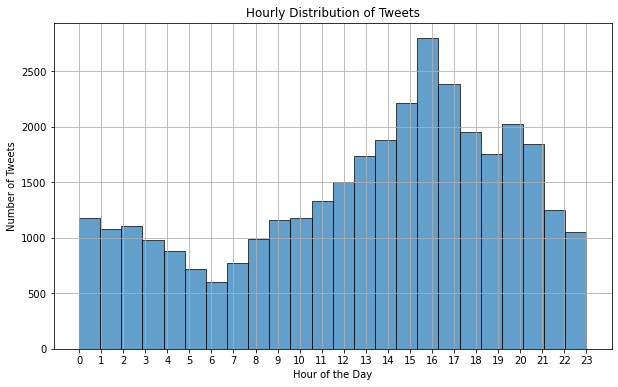

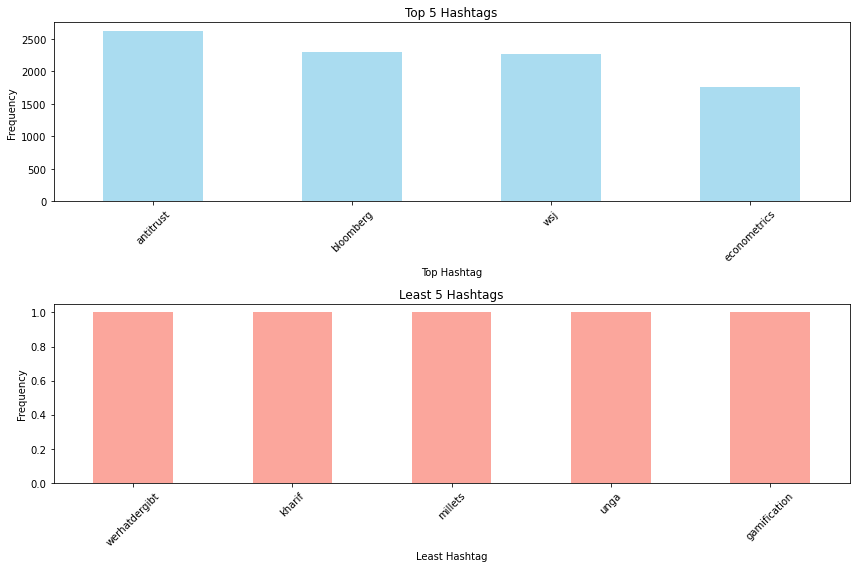

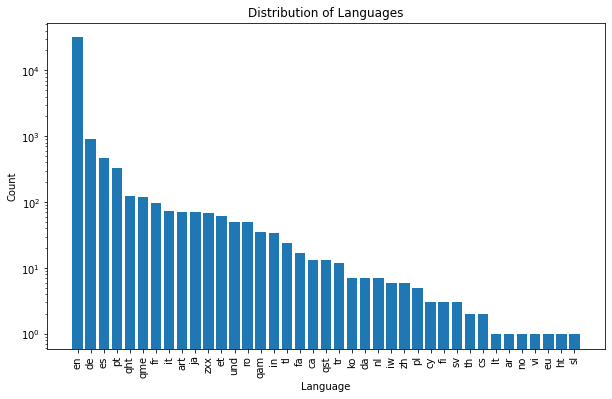

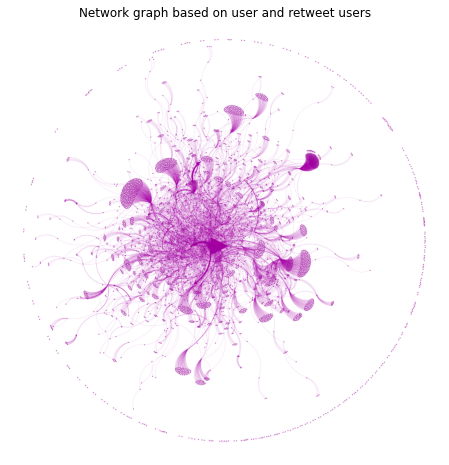

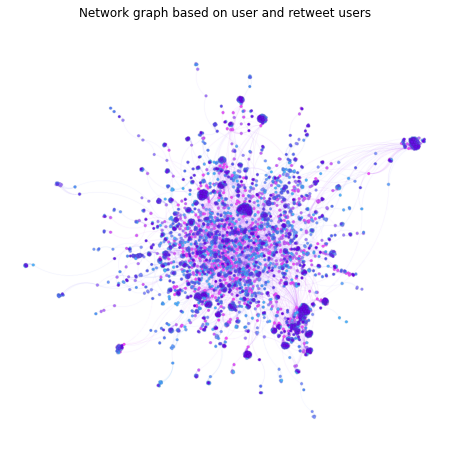

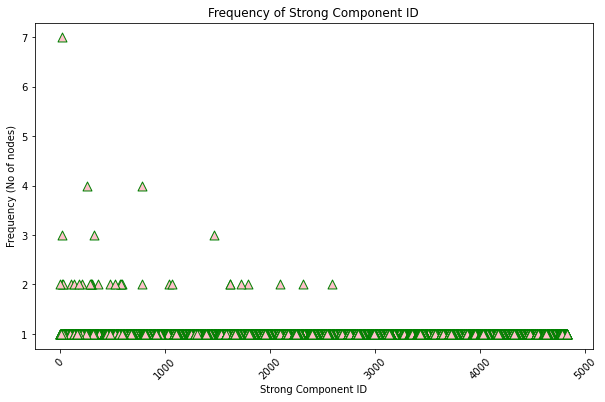

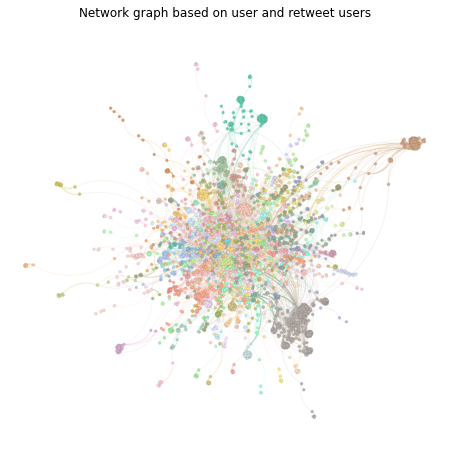

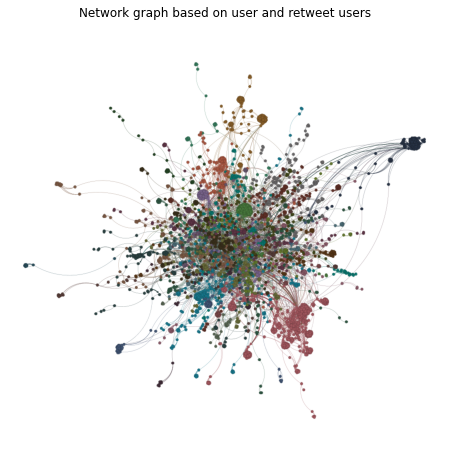

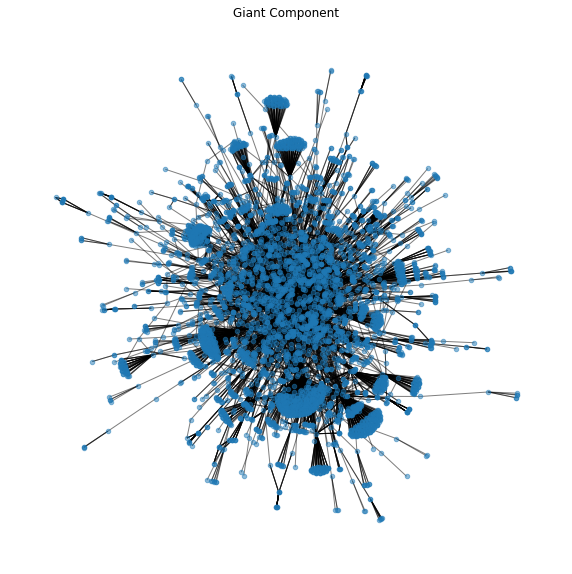

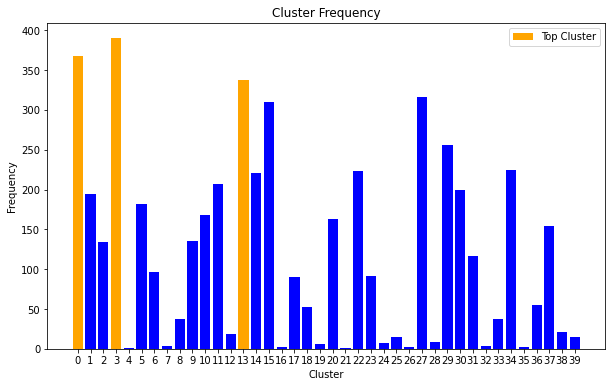

Top 3 clusters : [3, 0, 13]


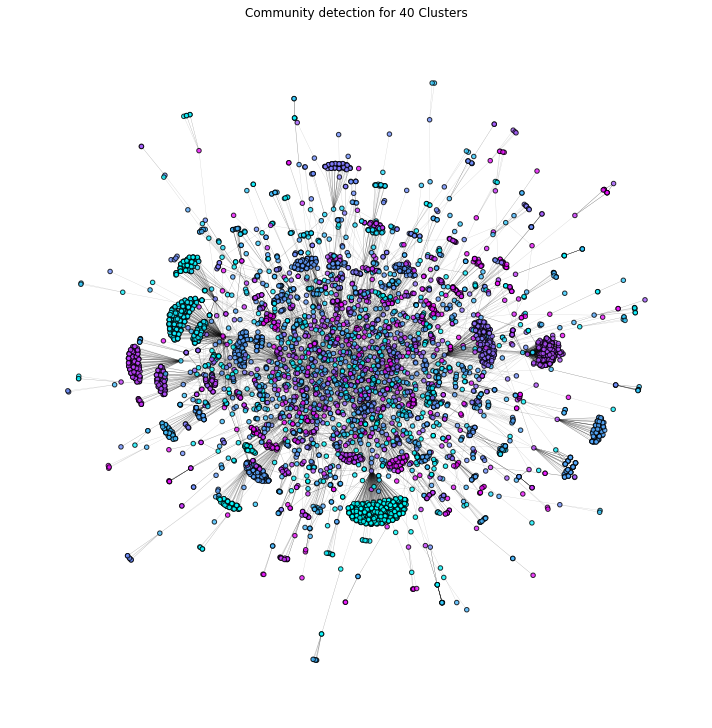

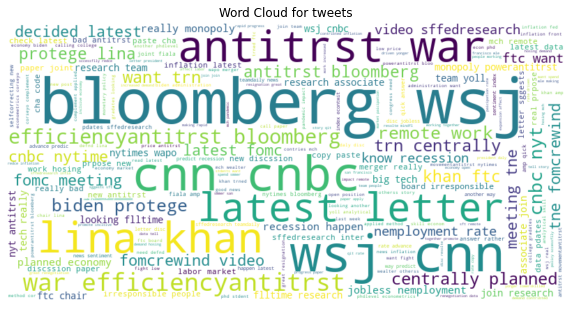

<Figure size 432x288 with 0 Axes>

Topic 4.0 :
(0, '0.966*"paper" + 0.024*"new" + 0.010*"research"')


(1, '0.923*"research" + 0.061*"new" + 0.017*"paper"')


(2, '0.978*"new" + 0.012*"paper" + 0.011*"research"')


Topic 10.0 :
(0, '0.374*"thank" + 0.362*"one" + 0.251*"jonathan" + 0.004*"paper" + 0.004*"labor" + 0.004*"market"')


(1, '0.520*"labor" + 0.415*"market" + 0.047*"paper" + 0.006*"one" + 0.006*"thank" + 0.006*"jonathan"')


(2, '0.945*"paper" + 0.019*"market" + 0.011*"labor" + 0.009*"one" + 0.008*"thank" + 0.008*"jonathan"')


Topic 18.0 :
(0, '0.283*"looking" + 0.240*"econometrics" + 0.164*"check" + 0.158*"paper" + 0.133*"amp" + 0.006*"market" + 0.003*"interested"')


(1, '0.211*"new" + 0.153*"interested" + 0.119*"paper" + 0.112*"answer" + 0.112*"rather" + 0.107*"amp" + 0.106*"qick"')


(2, '0.392*"market" + 0.294*"inflation" + 0.271*"fed" + 0.005*"looking" + 0.005*"check" + 0.005*"econometrics" + 0.004*"paper"')


accuracy:  0.6022727272727273


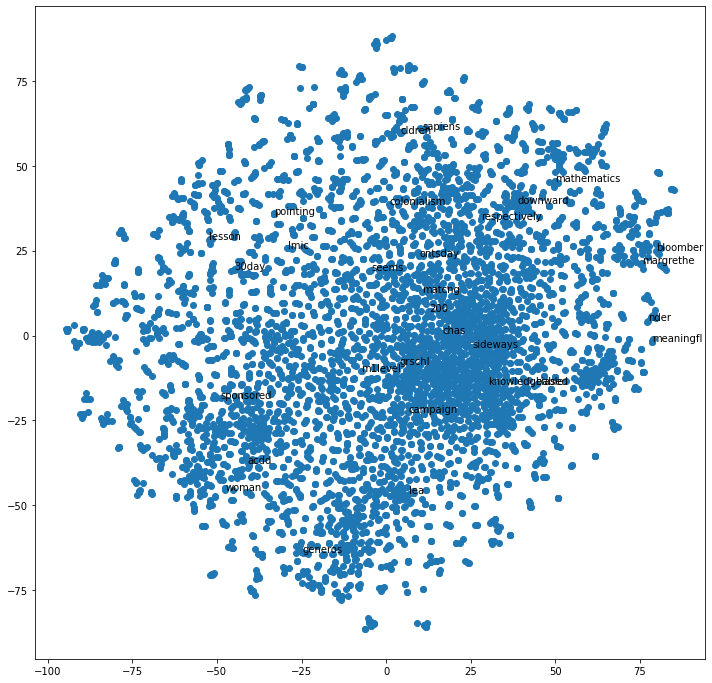

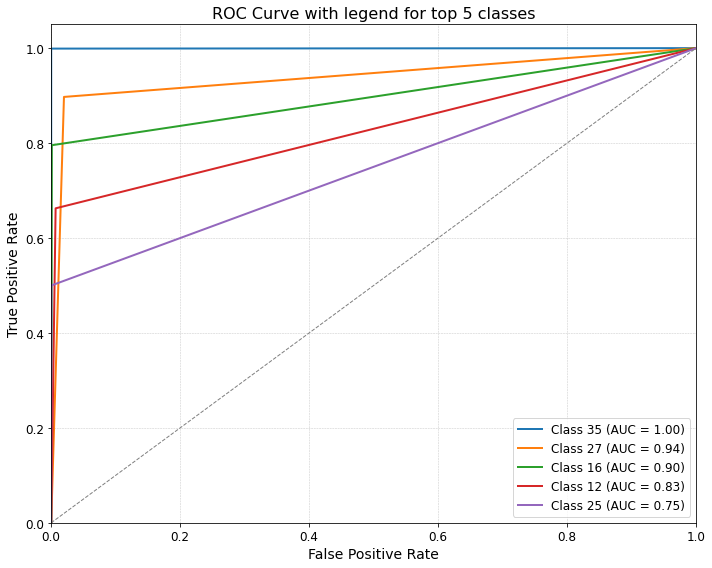

INFO: Adding senti scores and passing on as a feature
accuracy:  0.6045918367346939


In [24]:
t1 = datetime.datetime.now()
if __name__ == "__main__":
    main()
t2 = datetime.datetime.now()